In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from util.plotting import *
from datetime import date, datetime, time, timedelta
import json
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
# load incident data
path = f'data/clean/incident/2024-08-31/incident_stages.csv'
df = pd.read_csv(path)

status_lst = ['investigating', 'identified', 'monitoring', 'resolved', 'postmortem']
for status in status_lst:
    df[f'{status}_timestamp'] = pd.to_datetime(df[f'{status}_timestamp'])
    
df.head()

,incident_id,Incident_Title,incident_impact_level,Incident_color,provider,Playground,API,Labs,ChatGPT,api.anthropic.com,claude.ai,console.anthropic.com,Character.AI,investigating_flag,investigating_timestamp,investigating_description,identified_flag,identified_timestamp,identified_description,monitoring_flag,monitoring_timestamp,monitoring_description,resolved_flag,resolved_timestamp,resolved_description,postmortem_flag,postmortem_timestamp,postmortem_description,start_timestamp,close_timestamp,time_span,over_one_day
0,qv89mzdjvtrs,Elevated Errors,1,#f1c40f,anthropic,0,0,0,0,1,1,1,0,1,2024-02-26 17:09:00+00:00,We're experiencing an elevated level of API er...,1,2024-02-26 17:37:00+00:00,The issue has been identified and a fix is bei...,1,2024-02-26 17:41:00+00:00,A fix has been implemented and we are monitori...,1,2024-02-26 18:21:00+00:00,This incident has been resolved.,0,NaT,NaN,2024-02-26 17:09:00+00:00,2024-02-26 18:21:00+00:00,0 days 01:12:00,False
1,tmsczhzhjd63,Elevated error rate on claude.ai,0,#333333,anthropic,0,0,0,0,0,0,0,0,0,NaT,NaN,0,NaT,NaN,0,NaT,NaN,1,2024-02-16 20:35:00+00:00,We experienced an elevated level of errors on ...,0,NaT,NaN,2024-02-16 20:35:00+00:00,2024-02-16 20:35:00+00:00,0 days 00:00:00,False
2,t6v85cs8j6jb,"Elevated error rate on Claude-2.0, Claude-2.1",0,#333333,anthropic,0,0,0,0,1,1,1,0,1,2024-02-13 03:59:00+00:00,We are currently investigating this issue.,1,2024-02-13 04:21:00+00:00,The issue has been identified and a fix is bei...,1,2024-02-13 04:30:00+00:00,A fix has been implemented and we are monitori...,1,2024-02-13 04:36:00+00:00,This incident has been resolved.,0,NaT,NaN,2024-02-13 03:59:00+00:00,2024-02-13 04:36:00+00:00,0 days 00:37:00,False
3,x5f4s8nvkyqq,"Elevated error rate on Claude-2.0, Claude-2.1",0,#333333,anthropic,0,0,0,0,1,1,1,0,1,2024-02-13 00:21:00+00:00,We are currently investigating this issue.,1,2024-02-13 00:50:00+00:00,The issue has been identified and a fix is bei...,1,2024-02-13 00:59:00+00:00,A fix has been implemented and we are monitori...,1,2024-02-13 01:26:00+00:00,This incident has been resolved.,0,NaT,NaN,2024-02-13 00:21:00+00:00,2024-02-13 01:26:00+00:00,0 days 01:05:00,False
4,gr7nb0dwyydw,elevated error rates on claude-instant-1.2,0,#333333,anthropic,0,0,0,0,1,1,1,0,1,2024-02-05 23:07:00+00:00,We are currently investigating this issue.,0,NaT,NaN,1,2024-02-05 23:58:00+00:00,A fix has been implemented and we are monitori...,1,2024-02-06 01:55:00+00:00,This incident has been resolved.,0,NaT,NaN,2024-02-05 23:07:00+00:00,2024-02-06 01:55:00+00:00,0 days 02:48:00,False


In [3]:
# corner case filter
# check order of timestamp
count_lst = 5 * [0]
corner_cases = pd.DataFrame()

for index, record in df.iterrows():
    if record['investigating_timestamp'] > record['identified_timestamp']:
        count_lst[0] += 1
        corner_cases = pd.concat([corner_cases, record], axis=0)
    if record['identified_timestamp'] > record['monitoring_timestamp']:
        count_lst[1] += 1
        corner_cases = pd.concat([corner_cases, record], axis=0)
    if record['monitoring_timestamp'] > record['resolved_timestamp']:
        count_lst[2] += 1
        corner_cases = pd.concat([corner_cases, record], axis=0)
    if record['resolved_timestamp'] > record['postmortem_timestamp']:
        count_lst[3] += 1
        corner_cases = pd.concat([corner_cases, record], axis=0)
print(count_lst)

corner_cases = corner_cases.T
# display(corner_cases)

# filter out df corner cases
df = df.drop(corner_cases.index)
df = df.reset_index(drop=True)
df

[2, 3, 0, 0, 0]


,incident_id,Incident_Title,incident_impact_level,Incident_color,provider,Playground,API,Labs,ChatGPT,api.anthropic.com,claude.ai,console.anthropic.com,Character.AI,investigating_flag,investigating_timestamp,investigating_description,identified_flag,identified_timestamp,identified_description,monitoring_flag,monitoring_timestamp,monitoring_description,resolved_flag,resolved_timestamp,resolved_description,postmortem_flag,postmortem_timestamp,postmortem_description,start_timestamp,close_timestamp,time_span,over_one_day
0,qv89mzdjvtrs,Elevated Errors,1,#f1c40f,anthropic,0,0,0,0,1,1,1,0,1,2024-02-26 17:09:00+00:00,We're experiencing an elevated level of API er...,1,2024-02-26 17:37:00+00:00,The issue has been identified and a fix is bei...,1,2024-02-26 17:41:00+00:00,A fix has been implemented and we are monitori...,1,2024-02-26 18:21:00+00:00,This incident has been resolved.,0,NaT,NaN,2024-02-26 17:09:00+00:00,2024-02-26 18:21:00+00:00,0 days 01:12:00,False
1,tmsczhzhjd63,Elevated error rate on claude.ai,0,#333333,anthropic,0,0,0,0,0,0,0,0,0,NaT,NaN,0,NaT,NaN,0,NaT,NaN,1,2024-02-16 20:35:00+00:00,We experienced an elevated level of errors on ...,0,NaT,NaN,2024-02-16 20:35:00+00:00,2024-02-16 20:35:00+00:00,0 days 00:00:00,False
2,t6v85cs8j6jb,"Elevated error rate on Claude-2.0, Claude-2.1",0,#333333,anthropic,0,0,0,0,1,1,1,0,1,2024-02-13 03:59:00+00:00,We are currently investigating this issue.,1,2024-02-13 04:21:00+00:00,The issue has been identified and a fix is bei...,1,2024-02-13 04:30:00+00:00,A fix has been implemented and we are monitori...,1,2024-02-13 04:36:00+00:00,This incident has been resolved.,0,NaT,NaN,2024-02-13 03:59:00+00:00,2024-02-13 04:36:00+00:00,0 days 00:37:00,False
3,x5f4s8nvkyqq,"Elevated error rate on Claude-2.0, Claude-2.1",0,#333333,anthropic,0,0,0,0,1,1,1,0,1,2024-02-13 00:21:00+00:00,We are currently investigating this issue.,1,2024-02-13 00:50:00+00:00,The issue has been identified and a fix is bei...,1,2024-02-13 00:59:00+00:00,A fix has been implemented and we are monitori...,1,2024-02-13 01:26:00+00:00,This incident has been resolved.,0,NaT,NaN,2024-02-13 00:21:00+00:00,2024-02-13 01:26:00+00:00,0 days 01:05:00,False
4,gr7nb0dwyydw,elevated error rates on claude-instant-1.2,0,#333333,anthropic,0,0,0,0,1,1,1,0,1,2024-02-05 23:07:00+00:00,We are currently investigating this issue.,0,NaT,NaN,1,2024-02-05 23:58:00+00:00,A fix has been implemented and we are monitori...,1,2024-02-06 01:55:00+00:00,This incident has been resolved.,0,NaT,NaN,2024-02-05 23:07:00+00:00,2024-02-06 01:55:00+00:00,0 days 02:48:00,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532,qz0h6b7jw268,Outage on some Ada and Babbage models,2,#e86c09,openai,0,1,0,0,0,0,0,0,0,NaT,NaN,1,2022-07-07 06:07:00+00:00,We have identified an issue affecting some Ada...,1,2022-07-07 06:56:00+00:00,"We’ve moved affected models to other regions, ...",1,2022-07-07 08:12:00+00:00,All models have recovered and are operational....,1,2022-07-12 01:03:00+00:00,"Summary:\nOn July 6, 2022 22:17 PDT (July 7 05...",2022-07-07 06:07:00+00:00,2022-07-07 08:12:00+00:00,0 days 02:05:00,False
533,7h9pjy5d1lz5,Cluster Outage,2,#e86c09,openai,0,1,0,0,0,0,0,0,1,2022-06-24 02:02:00+00:00,One of our clusters has had an outage affectin...,1,2022-06-24 04:14:00+00:00,One of our clusters has suffered a major commu...,1,2022-06-24 06:03:00+00:00,We believe we have found a stable arrangement ...,1,2022-06-24 15:25:00+00:00,All models are operational. Thank you for you...,1,2022-06-28 03:20:00+00:00,"Summary:\nOn June 23, 2022 18:56 PDT (June 24 ...",2022-06-24 02:02:00+00:00,2022-06-24 15:25:00+00:00,0 days 13:23:00,False
534,jzk2gzhfc34g,Logged in websites unavailable,2,#e86c09,openai,1,0,0,0,0,0,0,0,1,2022-06-21 07:00:00+00:00,Investigating reports of Playground not being ...,1,2022-06-21 07:01:00+00:00,Playground & DALL-E websites are currently una...,1,2022-06-21 07:01:00+00:00,

In [4]:
# filter all flag == 1
df_incident = df[(df['investigating_flag'] == 1) & (df['identified_flag'] == 1) & (df['monitoring_flag'] == 1) & (df['resolved_flag'] == 1) & (df['postmortem_flag'] == 1)]
# display(df_incident)

# select an incident example
df_example = df[df['incident_id'] == 'w20mcckg1748']
display(df_example)

# select timestamp columns
timestamp_columns = [col for col in df.columns if 'timestamp' in col]
df_example_tmp = df_example[timestamp_columns]
for col in timestamp_columns:
    df_example_tmp[col] = pd.to_datetime(df_example_tmp[col])
    
df_example_tmp = df_example_tmp.T[:-3]
df_example_tmp.index = ['investigating', 'identified', 'monitoring', 'resolved']
df_example_tmp.columns = ['x']

# add estimate_value, for plotting
# Here we estimate the number of reports of each status manually using MA(Moving Average) method. 
# Because user reports was collected every 15 minutes interval, but the incident status was updated every 1 minutes.
# As the result, the timestamp of each status is:
print(f'The timestamp of each status is:{df_example_tmp}') 

estimate_value = [294+((328-294)/15)*4, 
                1410-((1410-285)/15)*2, 
                1410-((1410-285)/15)*12, 
                285-((285-136)/15)*4,
                ]
df_example_tmp['y'] = estimate_value
df_example_tmp


,incident_id,Incident_Title,incident_impact_level,Incident_color,provider,Playground,API,Labs,ChatGPT,api.anthropic.com,claude.ai,console.anthropic.com,Character.AI,investigating_flag,investigating_timestamp,investigating_description,identified_flag,identified_timestamp,identified_description,monitoring_flag,monitoring_timestamp,monitoring_description,resolved_flag,resolved_timestamp,resolved_description,postmortem_flag,postmortem_timestamp,postmortem_description,start_timestamp,close_timestamp,time_span,over_one_day
286,w20mcckg1748,Elevated errors in ChatGPT,2,#e86c09,openai,0,0,0,1,0,0,0,0,1,2024-04-10 17:56:00+00:00,We are currently investigating elevated errors...,1,2024-04-10 20:39:00+00:00,We have identified the source of the elevated ...,1,2024-04-10 20:49:00+00:00,Errors are continuing to resolve as a result o...,1,2024-04-10 20:56:00+00:00,At this time our deployed fix has mitigated th...,1,2024-04-18 00:01:00+00:00,"On April 10th between 11:00am - 1:43pm PST, a ...",2024-04-10 17:56:00+00:00,2024-04-10 20:56:00+00:00,0 days 03:00:00,False


The timestamp of each status is:                                      x
investigating 2024-04-10 17:56:00+00:00
identified    2024-04-10 20:39:00+00:00
monitoring    2024-04-10 20:49:00+00:00
resolved      2024-04-10 20:56:00+00:00


,x,y
investigating,2024-04-10 17:56:00+00:00,303.066667
identified,2024-04-10 20:39:00+00:00,1260.000000
monitoring,2024-04-10 20:49:00+00:00,510.000000
resolved,2024-04-10 20:56:00+00:00,245.266667


In [5]:
# table. parameter value for the selected incident
df_example_param = df_example[['incident_id', 'investigating_timestamp', 'identified_timestamp', 'monitoring_timestamp', 'resolved_timestamp', 'postmortem_timestamp']]
# rename columns
df_example_param.columns = ['Incident ID', 'S_1', 'S_2', 'S_3', 'S_4', 'S_5']
df_example_param['P_I'] = df_example_param['S_2'] - df_example_param['S_1']
df_example_param['P_R'] = df_example_param['S_3'] - df_example_param['S_2']
df_example_param['P_C'] = df_example_param['S_4'] - df_example_param['S_3']
df_example_param['P_L'] = df_example_param['S_5'] - df_example_param['S_4']
# transform to hours
df_example_param['P_I'] = df_example_param['P_I'].dt.total_seconds() / 3600
df_example_param['P_R'] = df_example_param['P_R'].dt.total_seconds() / 3600
df_example_param['P_C'] = df_example_param['P_C'].dt.total_seconds() / 3600
df_example_param['P_L'] = df_example_param['P_L'].dt.total_seconds() / 3600

df_example_param['Time To Resolve'] = df_example_param['S_4'] - df_example_param['S_1']
df_example_param['Time To Resolve'] = df_example_param['Time To Resolve'].dt.total_seconds() / 3600

# 2 digits
df_example_param = df_example_param.round(2)

display(df_example_param)

# latex
print(df_example_param.to_latex(index=False))


,Incident ID,S_1,S_2,S_3,S_4,S_5,P_I,P_R,P_C,P_L,Time To Resolve
286,w20mcckg1748,2024-04-10 17:56:00+00:00,2024-04-10 20:39:00+00:00,2024-04-10 20:49:00+00:00,2024-04-10 20:56:00+00:00,2024-04-18 00:01:00+00:00,2.72,0.17,0.12,171.08,3.0


\begin{tabular}{llllllrrrrr}
\toprule
Incident ID & S_1 & S_2 & S_3 & S_4 & S_5 & P_I & P_R & P_C & P_L & Time To Resolve \\
\midrule
w20mcckg1748 & 2024-04-10 17:56:00+00:00 & 2024-04-10 20:39:00+00:00 & 2024-04-10 20:49:00+00:00 & 2024-04-10 20:56:00+00:00 & 2024-04-18 00:01:00+00:00 & 2.720000 & 0.170000 & 0.120000 & 171.080000 & 3.000000 \\
\bottomrule
\end{tabular}



In [6]:
# user reports data at April 10, 2024, source from: https://web.archive.org/web/20240410235249/https://downdetector.com/status/openai/
data = [
                { 'x': '2024-04-09T23:52:20+00:00', 'y': 18 },
              
                { 'x': '2024-04-10T00:07:20+00:00', 'y': 12 },
              
                { 'x': '2024-04-10T00:22:20+00:00', 'y': 18 },
              
                { 'x': '2024-04-10T00:37:20+00:00', 'y': 13 },
              
                { 'x': '2024-04-10T00:52:20+00:00', 'y': 12 },
              
                { 'x': '2024-04-10T01:07:20+00:00', 'y': 15 },
              
                { 'x': '2024-04-10T01:22:20+00:00', 'y': 13 },
              
                { 'x': '2024-04-10T01:37:20+00:00', 'y': 11 },
              
                { 'x': '2024-04-10T01:52:20+00:00', 'y': 9 },
              
                { 'x': '2024-04-10T02:07:20+00:00', 'y': 10 },
              
                { 'x': '2024-04-10T02:22:20+00:00', 'y': 10 },
              
                { 'x': '2024-04-10T02:37:20+00:00', 'y': 19 },
              
                { 'x': '2024-04-10T02:52:20+00:00', 'y': 16 },
              
                { 'x': '2024-04-10T03:07:20+00:00', 'y': 14 },
              
                { 'x': '2024-04-10T03:22:20+00:00', 'y': 8 },
              
                { 'x': '2024-04-10T03:37:20+00:00', 'y': 12 },
              
                { 'x': '2024-04-10T03:52:20+00:00', 'y': 7 },
              
                { 'x': '2024-04-10T04:07:20+00:00', 'y': 7 },
              
                { 'x': '2024-04-10T04:22:20+00:00', 'y': 2 },
              
                { 'x': '2024-04-10T04:37:20+00:00', 'y': 4 },
              
                { 'x': '2024-04-10T04:52:20+00:00', 'y': 4 },
              
                { 'x': '2024-04-10T05:07:20+00:00', 'y': 4 },
              
                { 'x': '2024-04-10T05:22:20+00:00', 'y': 2 },
              
                { 'x': '2024-04-10T05:37:20+00:00', 'y': 8 },
              
                { 'x': '2024-04-10T05:52:20+00:00', 'y': 3 },
              
                { 'x': '2024-04-10T06:07:20+00:00', 'y': 2 },
              
                { 'x': '2024-04-10T06:22:20+00:00', 'y': 2 },
              
                { 'x': '2024-04-10T06:37:20+00:00', 'y': 0 },
              
                { 'x': '2024-04-10T06:52:20+00:00', 'y': 1 },
              
                { 'x': '2024-04-10T07:07:20+00:00', 'y': 3 },
              
                { 'x': '2024-04-10T07:22:20+00:00', 'y': 2 },
              
                { 'x': '2024-04-10T07:37:20+00:00', 'y': 3 },
              
                { 'x': '2024-04-10T07:52:20+00:00', 'y': 2 },
              
                { 'x': '2024-04-10T08:07:20+00:00', 'y': 0 },
              
                { 'x': '2024-04-10T08:22:20+00:00', 'y': 1 },
              
                { 'x': '2024-04-10T08:37:20+00:00', 'y': 4 },
              
                { 'x': '2024-04-10T08:52:20+00:00', 'y': 2 },
              
                { 'x': '2024-04-10T09:07:20+00:00', 'y': 3 },
              
                { 'x': '2024-04-10T09:22:20+00:00', 'y': 1 },
              
                { 'x': '2024-04-10T09:37:20+00:00', 'y': 0 },
              
                { 'x': '2024-04-10T09:52:20+00:00', 'y': 1 },
              
                { 'x': '2024-04-10T10:07:20+00:00', 'y': 0 },
              
                { 'x': '2024-04-10T10:22:20+00:00', 'y': 1 },
              
                { 'x': '2024-04-10T10:37:20+00:00', 'y': 0 },
              
                { 'x': '2024-04-10T10:52:20+00:00', 'y': 1 },
              
                { 'x': '2024-04-10T11:07:20+00:00', 'y': 1 },
              
                { 'x': '2024-04-10T11:22:20+00:00', 'y': 0 },
              
                { 'x': '2024-04-10T11:37:20+00:00', 'y': 1 },
              
                { 'x': '2024-04-10T11:52:20+00:00', 'y': 4 },
              
                { 'x': '2024-04-10T12:07:20+00:00', 'y': 2 },
              
                { 'x': '2024-04-10T12:22:20+00:00', 'y': 3 },
              
                { 'x': '2024-04-10T12:37:20+00:00', 'y': 3 },
              
                { 'x': '2024-04-10T12:52:20+00:00', 'y': 11 },
              
                { 'x': '2024-04-10T13:07:20+00:00', 'y': 5 },
              
                { 'x': '2024-04-10T13:22:20+00:00', 'y': 6 },
              
                { 'x': '2024-04-10T13:37:20+00:00', 'y': 5 },
              
                { 'x': '2024-04-10T13:52:20+00:00', 'y': 8 },
              
                { 'x': '2024-04-10T14:07:20+00:00', 'y': 4 },
              
                { 'x': '2024-04-10T14:22:20+00:00', 'y': 17 },
              
                { 'x': '2024-04-10T14:37:20+00:00', 'y': 12 },
              
                { 'x': '2024-04-10T14:52:20+00:00', 'y': 3 },
              
                { 'x': '2024-04-10T15:07:20+00:00', 'y': 13 },
              
                { 'x': '2024-04-10T15:22:20+00:00', 'y': 4 },
              
                { 'x': '2024-04-10T15:37:20+00:00', 'y': 11 },
              
                { 'x': '2024-04-10T15:52:20+00:00', 'y': 11 },
              
                { 'x': '2024-04-10T16:07:20+00:00', 'y': 7 },
              
                { 'x': '2024-04-10T16:22:20+00:00', 'y': 14 },
              
                { 'x': '2024-04-10T16:37:20+00:00', 'y': 12 },
              
                { 'x': '2024-04-10T16:52:20+00:00', 'y': 9 },
              
                { 'x': '2024-04-10T17:07:20+00:00', 'y': 74 },
              
                { 'x': '2024-04-10T17:22:20+00:00', 'y': 87 },
              
                { 'x': '2024-04-10T17:37:20+00:00', 'y': 303 },
              
                { 'x': '2024-04-10T17:52:20+00:00', 'y': 294 },
              
                { 'x': '2024-04-10T18:07:20+00:00', 'y': 328 },
              
                { 'x': '2024-04-10T18:22:20+00:00', 'y': 1213 },
              
                { 'x': '2024-04-10T18:37:20+00:00', 'y': 4201 },
              
                { 'x': '2024-04-10T18:52:20+00:00', 'y': 2984 },
              
                { 'x': '2024-04-10T19:07:20+00:00', 'y': 3432 },
              
                { 'x': '2024-04-10T19:22:20+00:00', 'y': 4428 },
              
                { 'x': '2024-04-10T19:37:20+00:00', 'y': 3021 },
              
                { 'x': '2024-04-10T19:52:20+00:00', 'y': 2910 },
              
                { 'x': '2024-04-10T20:07:20+00:00', 'y': 2691 },
              
                { 'x': '2024-04-10T20:22:20+00:00', 'y': 2308 },
              
                { 'x': '2024-04-10T20:37:20+00:00', 'y': 1410 },
              
                { 'x': '2024-04-10T20:52:20+00:00', 'y': 285 },
              
                { 'x': '2024-04-10T21:07:20+00:00', 'y': 136 },
              
                { 'x': '2024-04-10T21:22:20+00:00', 'y': 130 },
              
                { 'x': '2024-04-10T21:37:20+00:00', 'y': 94 },
              
                { 'x': '2024-04-10T21:52:20+00:00', 'y': 84 },
              
                { 'x': '2024-04-10T22:07:20+00:00', 'y': 78 },
              
                { 'x': '2024-04-10T22:22:20+00:00', 'y': 59 },
              
                { 'x': '2024-04-10T22:37:20+00:00', 'y': 60 },
              
                { 'x': '2024-04-10T22:52:20+00:00', 'y': 50 },
              
                { 'x': '2024-04-10T23:07:20+00:00', 'y': 68 },
              
                { 'x': '2024-04-10T23:22:20+00:00', 'y': 79 },
              
                { 'x': '2024-04-10T23:37:20+00:00', 'y': 75 },
              
]

df_report = pd.DataFrame(data)
# select timestamp after 2024-04-10T16:00:00+00:00
df_report['x'] = pd.to_datetime(df_report['x'], utc=True)
df_report = df_report[df_report['x'] >= '2024-04-10T17:00:00+00:00']
df_report = df_report.reset_index(drop=True)
df_report

,x,y
0,2024-04-10 17:07:20+00:00,74
1,2024-04-10 17:22:20+00:00,87
2,2024-04-10 17:37:20+00:00,303
3,2024-04-10 17:52:20+00:00,294
4,2024-04-10 18:07:20+00:00,328
5,2024-04-10 18:22:20+00:00,1213
6,2024-04-10 18:37:20+00:00,4201
7,2024-04-10 18:52:20+00:00,2984
8,2024-04-10 19:07:20+00:00,3432
9,2024-04-10 19:22:20+00:00,4428


In [7]:
df_example_tmp.loc['postmortem'] = [df_report['x'].iloc[-6], df_report['y'].iloc[-6]]  # set a postmortem status
df_example_tmp.loc['next_investigating'] = [df_report['x'].iloc[-5] + timedelta(minutes=0), 300]  # set a next_investigating status
df_example_tmp.loc['real_start_point'] = [df_report['x'].iloc[1] + timedelta(minutes=0), df_report['y'].iloc[1]]  # set a real start point
df_example_tmp = df_example_tmp.sort_values(by='x')
display(df_example_tmp)

df_test = pd.concat([df_example_tmp, df_report], axis=0)
df_test = df_test.sort_values(by='x')
df_test = df_test[df_test['x'] <= '2024-04-10T23:00:00+00:00']
df_test

,x,y
real_start_point,2024-04-10 17:22:20+00:00,87.000000
investigating,2024-04-10 17:56:00+00:00,303.066667
identified,2024-04-10 20:39:00+00:00,1260.000000
monitoring,2024-04-10 20:49:00+00:00,510.000000
resolved,2024-04-10 20:56:00+00:00,245.266667
postmortem,2024-04-10 22:22:20+00:00,59.000000
next_investigating,2024-04-10 22:37:20+00:00,300.000000


,x,y
0,2024-04-10 17:07:20+00:00,74.000000
real_start_point,2024-04-10 17:22:20+00:00,87.000000
1,2024-04-10 17:22:20+00:00,87.000000
2,2024-04-10 17:37:20+00:00,303.000000
3,2024-04-10 17:52:20+00:00,294.000000
investigating,2024-04-10 17:56:00+00:00,303.066667
4,2024-04-10 18:07:20+00:00,328.000000
5,2024-04-10 18:22:20+00:00,1213.000000
6,2024-04-10 18:37:20+00:00,4201.000000
7,2024-04-10 18:52:20+00:00,2984.000000


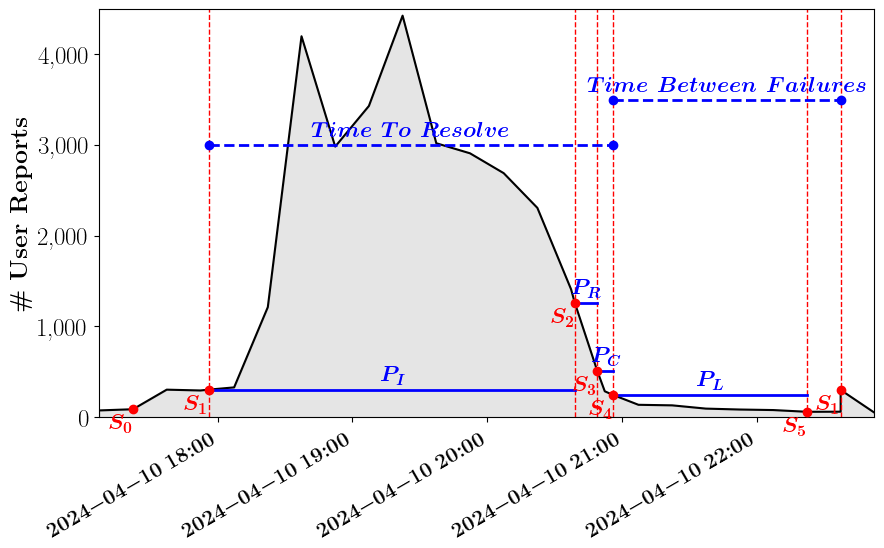

In [8]:
set_half_column_figure_font(height_multiplier=1.0)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
fig.subplots_adjust(wspace=0.0)

axes.plot(df_test['x'], df_test['y'], color='black', zorder=1, markersize=5)
# Fill the area under the line
axes.fill_between(df_test['x'], df_test['y'], color='black', alpha=0.1)

axes.scatter(df_example_tmp['x'], df_example_tmp['y'], color='red', zorder=5)
# show the incident status
axes.text(df_example_tmp['x'].iloc[0], df_example_tmp['y'].iloc[0]-50, r'\textbf{$S_0$}', color='red', fontsize=16, ha='right', va='top')
axes.text(df_example_tmp['x'].iloc[1], df_example_tmp['y'].iloc[1]-50, r'\textbf{$S_1$}', color='red', fontsize=16, ha='right', va='top')
axes.text(df_example_tmp['x'].iloc[2], df_example_tmp['y'].iloc[2]-50, r'\textbf{$S_2$}', color='red', fontsize=16, ha='right', va='top')
axes.text(df_example_tmp['x'].iloc[3], df_example_tmp['y'].iloc[3]-50, r'\textbf{$S_3$}', color='red', fontsize=16, ha='right', va='top')
axes.text(df_example_tmp['x'].iloc[4], df_example_tmp['y'].iloc[4]-50, r'\textbf{$S_4$}', color='red', fontsize=16, ha='right', va='top')
axes.text(df_example_tmp['x'].iloc[5], df_example_tmp['y'].iloc[5]-50, r'\textbf{$S_5$}', color='red', fontsize=16, ha='right', va='top')
axes.text(df_example_tmp['x'].iloc[6], df_example_tmp['y'].iloc[6]-50, r'\textbf{$S_1$}', color='red', fontsize=16, ha='right', va='top')

for x in df_example_tmp['x'][1:]:
    axes.axvline(x=x, color='red', linestyle='--', linewidth=1)

axes.plot([df_example_tmp['x'].iloc[1], df_example_tmp['x'].iloc[2]], [df_example_tmp['y'].iloc[1], df_example_tmp['y'].iloc[1]], color='blue', linestyle='-', linewidth=2, label='P1')
axes.plot([df_example_tmp['x'].iloc[2], df_example_tmp['x'].iloc[3]], [df_example_tmp['y'].iloc[2], df_example_tmp['y'].iloc[2]], color='blue', linestyle='-', linewidth=2, label='P2')
axes.plot([df_example_tmp['x'].iloc[3], df_example_tmp['x'].iloc[4]], [df_example_tmp['y'].iloc[3], df_example_tmp['y'].iloc[3]], color='blue', linestyle='-', linewidth=2, label='P3')
axes.plot([df_example_tmp['x'].iloc[4], df_example_tmp['x'].iloc[5]], [df_example_tmp['y'].iloc[4], df_example_tmp['y'].iloc[4]], color='blue', linestyle='-', linewidth=2, label='P4')
axes.plot([df_example_tmp['x'].iloc[1], df_example_tmp['x'].iloc[4]], [3000, 3000], color='blue', marker='o', linestyle='--', linewidth=2, label='MTTR')
axes.plot([df_example_tmp['x'].iloc[4], df_example_tmp['x'].iloc[6]], [3500, 3500], color='blue', marker='o', linestyle='--', linewidth=2, label='MTBF')

axes.text(df_example_tmp['x'].iloc[1] + (df_example_tmp['x'].iloc[2] - df_example_tmp['x'].iloc[1]) / 2, df_example_tmp['y'].iloc[1]+50, r'\textbf{$P_I$}', color='blue', fontsize=16, ha='center', va='bottom')
axes.text(df_example_tmp['x'].iloc[2] + (df_example_tmp['x'].iloc[3] - df_example_tmp['x'].iloc[2]) / 2, df_example_tmp['y'].iloc[2]+50, r'\textbf{$P_R$}', color='blue', fontsize=16, ha='center', va='bottom')
axes.text(df_example_tmp['x'].iloc[3] + (df_example_tmp['x'].iloc[4] - df_example_tmp['x'].iloc[3]) / 2, df_example_tmp['y'].iloc[3]+50, r'\textbf{$P_C$}', color='blue', fontsize=16, ha='center', va='bottom')
axes.text(df_example_tmp['x'].iloc[4] + (df_example_tmp['x'].iloc[5] - df_example_tmp['x'].iloc[4]) / 2, df_example_tmp['y'].iloc[4]+50, r'\textbf{$P_L$}', color='blue', fontsize=16, ha='center', va='bottom')
axes.text(df_example_tmp['x'].iloc[1] + (df_example_tmp['x'].iloc[4] - df_example_tmp['x'].iloc[1]) / 2, 3000+50, r'\textbf{$Time\ To\ Resolve$}', color='blue', fontsize=16, ha='center', va='bottom')
axes.text(df_example_tmp['x'].iloc[4] + (df_example_tmp['x'].iloc[6] - df_example_tmp['x'].iloc[4]) / 2, 3500+50, r'\textbf{$Time\ Between\ Failures$}', color='blue', fontsize=16, ha='center', va='bottom')

axes.set_xlim(df_test['x'].iloc[0], df_test['x'].iloc[-1])
axes.set_ylim(0, 4500)
axes.set_yticklabels(axes.get_yticks(), fontsize=18)
axes.set_xticklabels(axes.get_xticklabels(), fontsize=15)
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
axes.set_ylabel(r'\textbf{\# User Reports}', fontsize=18)
axes.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
fig.autofmt_xdate()

# save as pdf
plt.savefig('plot/sec2-failure_modeling/fig-F-R-modeling.pdf', format='pdf', bbox_inches='tight')
plt.show()
